# Import Required Libraries
Import necessary libraries including NumPy, Pandas, Matplotlib, Scikit-learn, and TensorFlow.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

2024-11-16 14:35:26.862731: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 14:35:27.045689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 14:35:27.132909: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 14:35:27.155395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 14:35:27.303636: I tensorflow/core/platform/cpu_feature_guar

# Load Dataset
Define a function to load the X-ray dataset from the given directory structure.

In [2]:
def load_path(path):
    """
    Load X-ray dataset from the given directory structure.
    """
    dataset = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for body in os.listdir(folder_path):
                body_path = os.path.join(folder_path, body)
                for patient_id in os.listdir(body_path):
                    patient_path = os.path.join(body_path, patient_id)
                    for label_folder in os.listdir(patient_path):
                        label = 'fractured' if label_folder.endswith('positive') else 'normal'
                        label_path = os.path.join(patient_path, label_folder)
                        for img in os.listdir(label_path):
                            img_path = os.path.join(label_path, img)
                            dataset.append({'label': body, 'image_path': img_path})
    return dataset

# Use current working directory
THIS_FOLDER = os.getcwd()
image_dir = os.path.join(THIS_FOLDER, 'Dataset')
data = load_path(image_dir)

# Prepare DataFrame
Create a DataFrame from the loaded dataset and add labels for each category.

In [3]:
THIS_FOLDER = os.getcwd()
image_dir = os.path.join(THIS_FOLDER, 'Dataset')
data = load_path(image_dir)

labels = []
filepaths = []

Labels = ["Elbow", "Hand", "Shoulder"]
for row in data:
    labels.append(row['label'])
    filepaths.append(row['image_path'])

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

# Display the first few rows of the DataFrame to verify
images.head()

,Filepath,Label
0,/home/arnav/xray-fracture-detection/Dataset/te...,Shoulder
1,/home/arnav/xray-fracture-detection/Dataset/te...,Shoulder
2,/home/arnav/xray-fracture-detection/Dataset/te...,Shoulder
3,/home/arnav/xray-fracture-detection/Dataset/te...,Shoulder
4,/home/arnav/xray-fracture-detection/Dataset/te...,Shoulder


# Split Dataset
Split the dataset into training and testing sets, and further split the training set into training and validation sets.

In [4]:
train_df, test_df = train_test_split(images, train_size=0.9, shuffle=True, random_state=1)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 14641 validated image filenames belonging to 3 classes.
Found 3660 validated image filenames belonging to 3 classes.
Found 2034 validated image filenames belonging to 3 classes.


# Build Model
Build a model using a pre-trained ResNet50 model with additional dense layers.

In [5]:
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(50, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(Labels), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

print(model.summary())

I0000 00:00:1731747931.008641    3558 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731747931.179635    3558 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731747931.179683    3558 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731747931.183248    3558 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731747931.183301    3558 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,856,587 (91.01 MB)

 Trainable params: 268,875 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


# Compile Model
Compile the model using the Adam optimizer with a low learning rate.

In [6]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
Train the model using the training and validation data, with early stopping to prevent overfitting.

In [7]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_images, validation_data=val_images, epochs=25, callbacks=[callbacks])

model.save(os.path.join(THIS_FOLDER, "weights/ResNet50_BodyParts.h5"))

/home/arnav/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1731747940.303930    3774 service.cc:146] XLA service 0x7fb9c8014980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731747940.303961    3774 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-16 14:35:40.420682: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-16 14:35:41.076111: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-16 14:35:42.412082: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5712', 176 bytes spill stores, 468 bytes spill loads

2024-11-16 14:35:42.451101: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local mem

 41/229 ━━━━━━━━━━━━━━━━━━━━ 35s 188ms/step - accuracy: 0.5993 - loss: 0.8712

2024-11-16 14:35:59.288382: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5712', 16 bytes spill stores, 16 bytes spill loads

2024-11-16 14:35:59.943663: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5712', 176 bytes spill stores, 176 bytes spill loads

2024-11-16 14:36:01.558248: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5937', 428 bytes spill stores, 428 bytes spill loads

2024-11-16 14:36:01.618784: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5937', 436 bytes spill stores, 436 bytes spill loads



229/229 ━━━━━━━━━━━━━━━━━━━━ 82s 299ms/step - accuracy: 0.8532 - loss: 0.3684 - val_accuracy: 0.9896 - val_loss: 0.0407
Epoch 2/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 43s 186ms/step - accuracy: 0.9912 - loss: 0.0302 - val_accuracy: 0.9915 - val_loss: 0.0332
Epoch 3/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 43s 187ms/step - accuracy: 0.9944 - loss: 0.0194 - val_accuracy: 0.9918 - val_loss: 0.0284
Epoch 4/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - accuracy: 0.9964 - loss: 0.0126 - val_accuracy: 0.9940 - val_loss: 0.0214
Epoch 5/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 43s 189ms/step - accuracy: 0.9988 - loss: 0.0082 - val_accuracy: 0.9943 - val_loss: 0.0193
Epoch 6/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 43s 186ms/step - accuracy: 0.9984 - loss: 0.0081 - val_accuracy: 0.9940 - val_loss: 0.0194
Epoch 7/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/step - accuracy: 0.9989 - loss: 0.0063 - val_accuracy: 0.9937 - val_loss: 0.0180
Epoch 8/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 49s 212ms/step - accuracy: 0.9998 - loss: 0.0037 - val

In [8]:
model.save(os.path.join(THIS_FOLDER, "weights/ResNet50_BodyParts.keras"))

# Evaluate Model
Evaluate the model on the test data and print the test accuracy.

In [9]:
results = model.evaluate(test_images, verbose=0)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100, 2)}%")

2024-11-16 14:48:58.104279: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1712', 176 bytes spill stores, 468 bytes spill loads

2024-11-16 14:49:07.991184: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1712', 12 bytes spill stores, 12 bytes spill loads

2024-11-16 14:49:07.993834: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1712', 176 bytes spill stores, 176 bytes spill loads



[0.017678648233413696, 0.9941002726554871]
Test Accuracy: 99.41%


# Plot Accuracy and Loss
Plot the accuracy and loss for both training and validation sets over the epochs.

[0.017678648233413696, 0.9941002726554871]
Test Accuracy: 99.41%


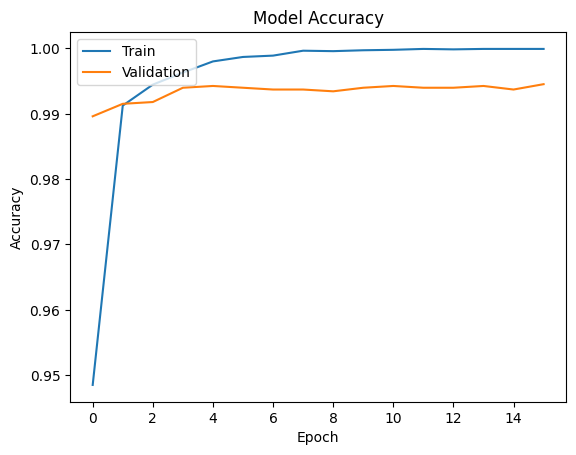

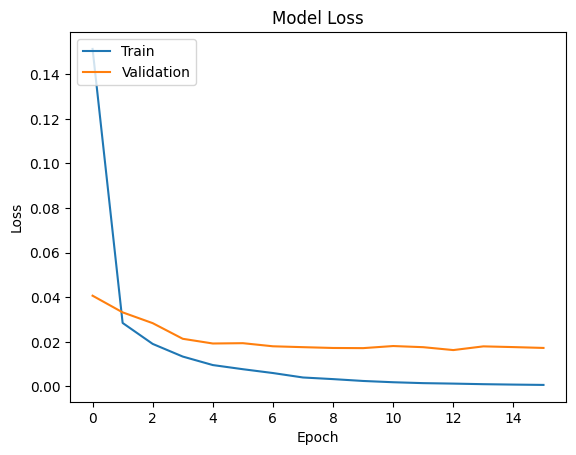

In [10]:
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100, 2)}%")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()